# 神经网络-图片分类
----------------------------
使用CIFAR10数据集。CIFAR10数据集包含60,000张32x32的彩色图片，10个类别，每个类包含6,000张。其中50,000张图片作为训练集，1000张作为验证集，10000作为测试集。对其中的猫和狗两类进行预测。

--------------------------------------------------
* 导入需要的包
* 数据加载及预处理
    * 加载数据，并分为训练集、验证集、测试集（打印数据形状并可视化部分数据）
    * 数据处理：归一化，减去训练集的均值并除以标准差
    * 将标签转换为 onehot
* 配置神经网络
    * 定义网络结构
    * 设置超参数。学习率、epoch等
    * 设置运行设备：cpu/GPU
    * 设置网络参数：输入、输出、权重、偏差等
    * 定义损失函数、优化器
* 训练神经网络
    * 将数据转换为能够按批次遍历的类
    * 训练并保存模型
    * 可视化loss和acuracy
* 模型调用，预测图片
    * 加载图像，将图像转换为模型的输入形状
    * 加载模型
    * 从模型中获取张量
    * sess，预测图片对应的标签
    * 将标签转换为对应的类别
----------------------------------------------------------    
author：武栋；date:2019/4/25；环境：tensorflow-python3.6

-----------------------------------------

## 导入需要的包

os:提供了丰富的方法来处理文件和目录

In [2]:
import os
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt

# 使matplotlib显示在该文本中，而不是一个新窗口中
# 使用matplotlib的rcParams设置参数，图像大小、插入、颜色style
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

D:\software\Anaconda3\soft\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 数据加载及预处理

构架数据加载函数load_cifar10

下载数据，并分为训练集、测试集、验证集；

In [15]:
def load_cifar10(num_training=49000, num_validation=1000, num_test=10000):
    """
    从网上下载cifar10数据集
    """
    #加载原始CIFAR-10数据集，并使用适当的数据类型和形状
    cifar10 = tf.keras.datasets.cifar10.load_data()
    (X_train, y_train), (X_test, y_test) = cifar10
    X_train = np.asarray(X_train, dtype=np.float32)
    y_train = np.asarray(y_train, dtype=np.int32).flatten()
    X_test = np.asarray(X_test, dtype=np.float32)
    y_test = np.asarray(y_test, dtype=np.int32).flatten()

    # 将数据集分为训练集、测试集、验证集
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    return X_train, y_train, X_val, y_val, X_test, y_test


调用上面的函数来获取数据。

In [16]:
NHW = (0, 1, 2)
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10()

打印数据形状，并可视化部分数据

In [17]:
print('训练集数据形状: ', X_train.shape)
print('训练label形状: ', y_train.shape, y_train.dtype)
print('验证集数据形状 ', X_val.shape)
print('验证集label形状 ', y_val.shape)
print('测试集数据形状 ', X_test.shape)
print('测试集label形状 ', y_test.shape)

训练集数据形状:  (49000, 32, 32, 3)
训练label形状:  (49000,) int32
验证集数据形状  (1000, 32, 32, 3)
验证集label形状  (1000,)
测试集数据形状  (10000, 32, 32, 3)
测试集label形状  (10000,)


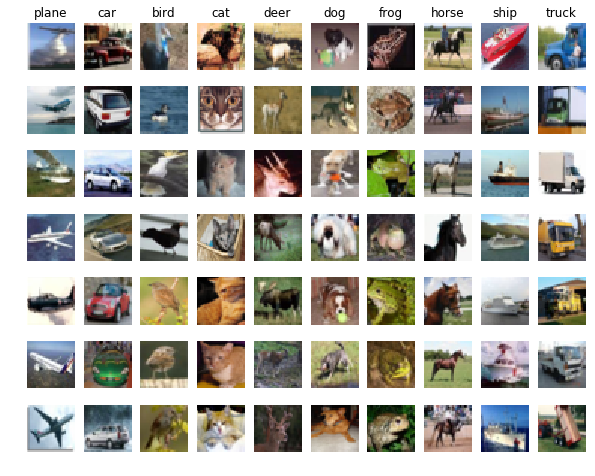

In [18]:
# 从数据集中可视化部分样本
# 展示了来自每个类别的一些训练图像的例子。
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y) # 返回矩阵y_train扁平化后值为y的位置，返回类别索引为y的数组
    idxs = np.random.choice(idxs, samples_per_class, replace=False) # 从该类别中随机取出7个样本，得到样本的位置
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1 #plot中y表示列，i表示行，使用plt_idx表示图的位置
        plt.subplot(samples_per_class, num_classes, plt_idx) #设置plot的长宽
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off') #隐藏坐标轴
        if i == 0:
            plt.title(cls) #在第0行显示名称
plt.show()

### 数据预处理，归一化：减去训练集的均值除以标准差

In [19]:
 # 数据归一化:减去平均像素，再除以标准差std
mean_pixel = X_train.mean(axis=(0, 1, 2), keepdims=True)
std_pixel = X_train.std(axis=(0, 1, 2), keepdims=True)
X_train = (X_train - mean_pixel) / std_pixel
X_val = (X_val - mean_pixel) / std_pixel
X_test = (X_test - mean_pixel) / std_pixel

### 将标签转换为 onehot

In [20]:
def one_hot_encode(x):
    """
        argument
            - x: 标签数组
        return
            - one hot encoding 矩阵(标签数量, 类别数量)
    """
    encoded = np.zeros((len(x), 10))
    
    for idx, val in enumerate(x):
        encoded[idx][val] = 1
    
    return encoded

In [21]:
y_train = one_hot_encode(y_train)
y_val = one_hot_encode(y_val)
y_test= one_hot_encode(y_test)

In [22]:
print(y_train.shape)

(49000, 10)


## 配置卷积神经网络

包括网络结构、损失函数、优化函数

### 网络结构

结构：
* conv1+conv1_maxpool+conv1_bn
* conv2+conv2_maxpool+conv2_bn
* conv3+conv3_maxpool+conv3_bn
* conv4+conv4_maxpool+conv4_bn
* fc1
* fc2

In [23]:
def conv_net(x):
    conv1_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 3, 64], mean=0, stddev=0.08))
    conv2_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 64, 128], mean=0, stddev=0.08))
    conv3_filter = tf.Variable(tf.truncated_normal(shape=[5, 5, 128, 256], mean=0, stddev=0.08))
    conv4_filter = tf.Variable(tf.truncated_normal(shape=[5, 5, 256, 512], mean=0, stddev=0.08))

    # 1, 2
    conv1 = tf.nn.conv2d(x, conv1_filter, strides=[1,1,1,1], padding='SAME')
    conv1 = tf.nn.relu(conv1)
    conv1_pool = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    conv1_bn = tf.layers.batch_normalization(conv1_pool)

    # 3, 4
    conv2 = tf.nn.conv2d(conv1_bn, conv2_filter, strides=[1,1,1,1], padding='SAME')
    conv2 = tf.nn.relu(conv2)
    conv2_pool = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')    
    conv2_bn = tf.layers.batch_normalization(conv2_pool)
  
    # 5, 6
    conv3 = tf.nn.conv2d(conv2_bn, conv3_filter, strides=[1,1,1,1], padding='SAME')
    conv3 = tf.nn.relu(conv3)
    conv3_pool = tf.nn.max_pool(conv3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')  
    conv3_bn = tf.layers.batch_normalization(conv3_pool)
    
    # 7, 8
    conv4 = tf.nn.conv2d(conv3_bn, conv4_filter, strides=[1,1,1,1], padding='SAME')
    conv4 = tf.nn.relu(conv4)
    conv4_pool = tf.nn.max_pool(conv4, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    conv4_bn = tf.layers.batch_normalization(conv4_pool)
    
    # 9
    flat = tf.contrib.layers.flatten(conv4_bn)  

    # 10
    full1 = tf.contrib.layers.fully_connected(inputs=flat, num_outputs=128, activation_fn=tf.nn.relu)
    full1 = tf.layers.batch_normalization(full1)
    
    # 11
    full2 = tf.contrib.layers.fully_connected(inputs=full1, num_outputs=256, activation_fn=tf.nn.relu)
    full2 = tf.layers.batch_normalization(full2)
    
    # 12
    out = tf.contrib.layers.fully_connected(inputs=full2, num_outputs=10, activation_fn=None)
    return out

### 设置超参数

In [24]:
num_epochs = 10
batch_size = 128
learning_rate = 0.001

### 设置运行在cpu/GPU

In [25]:
# 使用GPU
USE_GPU = True

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

## 设置网络参数：
 
* 输入、权重、偏差等

In [26]:
# 删除以前的权重、偏差、输入等。
tf.reset_default_graph()
with tf.device(device):
    # 输入
    x_data = tf.placeholder(tf.float32, shape=(None, 32, 32, 3), name='input_x')
    y_label = tf.placeholder(tf.int32, shape=[None ,10], name='output_y')


### 损失函数和优化器

In [27]:
# 计算模型，得到scores
logits = conv_net(x_data)
model = tf.identity(logits, name='logits') # 命名 logits ，从而可以保存到模型中在预测时使用

# 损失和优化器
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_label))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

# 定义accuracy，在sess中可以获取计算
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y_label, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



## 训练神经网络

### 定义一个类，遍历数据

实现按批次遍历数据和标签。

In [28]:
class Dataset(object):
    def __init__(self, X, y, batch_size, shuffle=False):
        """
        构造一个Dataset对象来遍历数据X和标签y
        
        Inputs:0
        - X: 数据的Numpy数组, 任何形状的
        - y: 标签的Numpy数组, 任何形状，但是y.shape[0] == X.shape[0]
        - batch_size: 整数，表示每个小批处理的元素数量
        - shuffle: (可选) Boolean
        """
        assert X.shape[0] == y.shape[0], '得到不同数量的数据和标签'
        self.X, self.y = X, y
        self.batch_size, self.shuffle = batch_size, shuffle

    def __iter__(self):
        N, B = self.X.shape[0], self.batch_size
        idxs = np.arange(N)
        if self.shuffle:
            np.random.shuffle(idxs)
        return iter((self.X[i:i+B], self.y[i:i+B]) for i in range(0, N, B))


train_dset = Dataset(X_train, y_train, batch_size=batch_size, shuffle=True)
val_dset = Dataset(X_val, y_val, batch_size=batch_size, shuffle=False)
test_dset = Dataset(X_test, y_test, batch_size=batch_size)

In [29]:
# 可以这样迭代数据集:
for t, (x, y) in enumerate(train_dset):
    print(t, x.shape, y.shape)
    if t > 5: break

0 (128, 32, 32, 3) (128, 10)
1 (128, 32, 32, 3) (128, 10)
2 (128, 32, 32, 3) (128, 10)
3 (128, 32, 32, 3) (128, 10)
4 (128, 32, 32, 3) (128, 10)
5 (128, 32, 32, 3) (128, 10)
6 (128, 32, 32, 3) (128, 10)


## 训练并保存模型

In [30]:
# 在训练时，用作检查验证数据的精度；将数据分成小批次进行预测，防止内存溢出
def check_acc(data,logits,sess): #防止溢出
    num_correct, num_samples = 0, 0
    for x_batch, y_batch in data:
        feed_dict = {x_data: x_batch}
        scores_np = sess.run(logits, feed_dict=feed_dict)
        y_pred = scores_np.argmax(axis=1) #得到每行中最大值的索引，即所属的类别标签，得到该批次数据预测得到的类别
        y_turth = np.array(y_batch).argmax(axis=1) # 将onehot标签转换为（N，）
        num_samples += x_batch.shape[0] #得到该数据的数目
        num_correct += np.sum(y_pred==y_turth) #得到判断正确的数据的数目
    acc = float(num_correct) / num_samples
    return acc
        

In [31]:
import time
# 存储模型的路径
save_model_path = './model/catdog_model'

print('Training...')
# 控制在训练模型时打印的频率
print_every = 100
# 用来存储训练过程中，训练精度、验证精度、loss的值
train_acc_array = []
val_acc_array = []
loss_array = []

# 创建一个本地session来进行训练
start_time = time.time()
with tf.Session() as sess:
    # 初始化变量
    sess.run(tf.global_variables_initializer())
    # 训练
    i = 0
    for epoch in range(num_epochs): # num_epochs表示整个训练集训练的轮数
        for it, (x_batch, y_batch) in enumerate(train_dset): # 按批次大小遍历训练数据集
            # 在一批训练数据上运行graph
            feed_dict = {x_data: x_batch, y_label: y_batch}
            # 运行优化器来更新权重
            sess.run(optimizer, feed_dict =feed_dict)
            # 定期打印loss并检查val的准确性
            if i % print_every == 0:
                # 获取此时的loss,scores的值
                l,scores = sess.run([loss,logits], feed_dict=feed_dict)
                # 获取时间间隔
                elapsed_time = time.time() - start_time
                start_time = time.time()
                loss_array.append(l)
                print('epoch %a/%d ,Iteration %d, loss = %.4f,  %.1f ms' % (epoch,num_epochs,i, l,1000 * elapsed_time / print_every))
                # 获取该批次数据的训练精度
                train_acc = sess.run(accuracy,  feed_dict={x_data: x_batch,y_label: y_batch })
                train_acc_array.append(train_acc)
                # 使用此时的模型预测验证集的精度，对模型进行评估
                val_acc = check_acc(val_dset,logits,sess )
                val_acc_array.append(val_acc)
                print('train_acc= %.4f,  val_acc = %.4f' % (train_acc,val_acc))
            i = i + 1
    # 最后检查测试集的精度
    test_acc = check_acc(test_dset,logits,sess )
    print('test_acc= %.4f,',test_acc)
    # 保存模型
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
epoch 0/10 ,Iteration 0, loss = 16.2959,  86.9 ms
train_acc= 0.0859,  val_acc = 0.0950
epoch 0/10 ,Iteration 100, loss = 1.5556,  47.3 ms
train_acc= 0.4219,  val_acc = 0.4070
epoch 0/10 ,Iteration 200, loss = 1.2434,  45.2 ms
train_acc= 0.5234,  val_acc = 0.5560
epoch 0/10 ,Iteration 300, loss = 1.1599,  45.3 ms
train_acc= 0.5703,  val_acc = 0.5660
epoch 1/10 ,Iteration 400, loss = 0.9513,  47.5 ms
train_acc= 0.6719,  val_acc = 0.6510
epoch 1/10 ,Iteration 500, loss = 0.8746,  45.3 ms
train_acc= 0.7109,  val_acc = 0.6650
epoch 1/10 ,Iteration 600, loss = 0.8111,  45.3 ms
train_acc= 0.7109,  val_acc = 0.6400
epoch 1/10 ,Iteration 700, loss = 0.6462,  45.2 ms
train_acc= 0.7656,  val_acc = 0.6840
epoch 2/10 ,Iteration 800, loss = 0.5106,  45.2 ms
train_acc= 0.8203,  val_acc = 0.7040
epoch 2/10 ,Iteration 900, loss = 0.3937,  45.3 ms
train_acc= 0.8750,  val_acc = 0.7240
epoch 2/10 ,Iteration 1000, loss = 0.5401,  45.3 ms
train_acc= 0.8594,  val_acc = 0.7040
epoch 2/10 ,Iteratio

### 可视化loss和accuracy

range(0, 39)


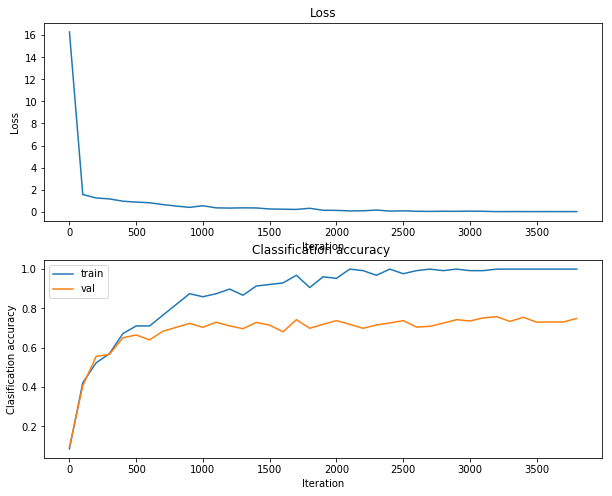

In [32]:
# 绘制损失函数和训练/验证精度
plt.subplot(2, 1, 1) # 设置两个子图，以及该图的位置
print(range(0,len(loss_array)))

plt.plot(range(0,100*len(loss_array),100),loss_array) # 输入数据，loss
plt.title('Loss') #标题
plt.xlabel('Iteration') # x轴
plt.ylabel('Loss') # y轴

plt.subplot(2, 1, 2) # 设置该图的位置
plt.plot(range(0,100*len(train_acc_array),100),train_acc_array, label='train') # 设置数据及标签
plt.plot(range(0,100*len(val_acc_array),100),val_acc_array, label='val') #设置验证数据及标签
plt.title('Classification accuracy ')
plt.xlabel('Iteration')
plt.ylabel('Clasification accuracy')
plt.legend()
plt.show()

## 模型调用，预测图片

调用文件夹中训练好的模型，对图片进行预测

* 加载图像，将图像转换为模型的输入形状
* 加载模型
* 从模型中获取张量
* sess，预测图片对应的标签
* 将标签转换为对应的类别

im_shape的维度： (1, 32, 32, 3)
INFO:tensorflow:Restoring parameters from ./model/catdog_model
推理的标签: [5]


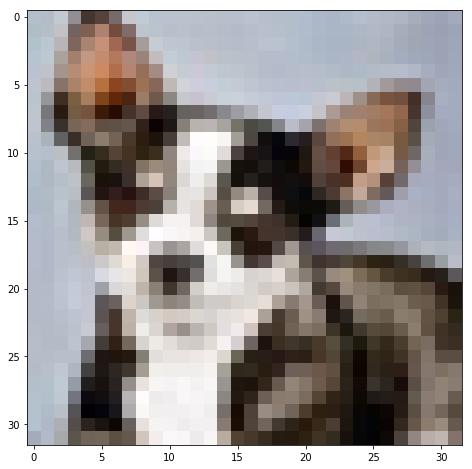

推理的结果: dog


In [3]:
save_model_path = './model/catdog_model'
from PIL import Image

# 将图片转换为输入模型的张量
def load_image(file):
        #打开图片
        im = Image.open(file)
        #将图片调整为跟训练数据一样的大小  32*32，设定ANTIALIAS，即抗锯齿.resize是缩放
        im = im.resize((32, 32), Image.ANTIALIAS)
        #建立图片矩阵 类型为float32
        im = np.array(im).astype(np.float32)
        #矩阵转置 
        # im = im.transpose((2, 1, 0))  # CHW，因为输入图像格式为[N，C，H，W]
        #将像素值从【0-255】转换为【0-1】
        im = im / 255.0

        # 保持和之前输入image维度一致
        im = np.expand_dims(im, axis=0)
        print('im_shape的维度：',im.shape)
        return im

def test_model():
    img = load_image('infer/dog.png')
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # 加载模型
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # 从加载好的模型中获取张量
        loaded_x = loaded_graph.get_tensor_by_name('input_x:0')
        loaded_y = loaded_graph.get_tensor_by_name('output_y:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # 预测图片，得到预测的标签的索引
        results = sess.run(
            tf.nn.softmax(loaded_logits),
            feed_dict={loaded_x: img})
        print( "推理的标签: %s" %results.argmax(axis=1))
        
        # 显示要预测的图像
        img = Image.open('infer/dog.png')
        plt.imshow(img)   #根据数组绘制图像
        plt.show()        #显示图像
        
        # 将标签索引转换为对应的类别
        label_list = [
        "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse",
        "ship", "truck"
        ]
        print("推理的结果: %s" % label_list[np.argmax(results)])

test_model()